In [1]:
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.sin(train_x * (2 * math.pi)) + 2 * torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    -torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

print(train_x.shape, train_y.shape)

torch.Size([100]) torch.Size([100, 4])


In [3]:
import numpy as np 
def get_inducing_points(x, num_latents, num_inducing_points):
    out = []
    for _ in range(num_latents):
        rid = torch.randperm(train_x.size(0))[:num_inducing_points]
        u = train_x[rid,...]
        out.append(u)
    out = torch.stack(out)

    return out.unsqueeze(2)


In [4]:
num_latents = 2
num_tasks = 4
inducing_points = get_inducing_points(train_x, num_latents, 8)
inducing_points.shape

torch.Size([2, 8, 1])

In [5]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        num_latents = inducing_points.size(0)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = MultitaskGPModel(inducing_points)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

In [6]:
num_epochs = 500

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_2752/3666224314.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

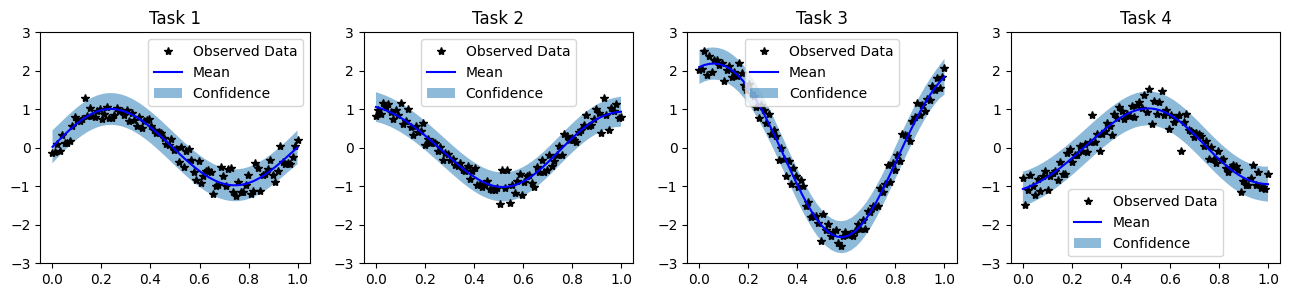

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

for task, ax in enumerate(axs):
    ax.plot(train_x.detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    ax.plot(test_x.numpy(), mean[:, task].numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')